In [1]:
# Title: DMRG for Bachelor Thesis
# Author: Aaron Sander
# Date: March-April 2020

# This program is used for initial learning of tensor network methods
# to be used in my bachelor thesis.
# It is an implementation of Matrix Product States (MPS) and Density Matrix
# Renormalization Group (DMRG) for compressing an arbitrary quantum state
# which has relevant applications in data compression and graph embedding.

### NOTE: This code is written for learning purposes. It is not meant
###       to be optimized for speed/efficiency, but has readability in mind.

In [2]:
######################### IMPORTS #############################################
from benchmarks import *
from canonical_forms import *
from classes import *
from compression import *
from contractions import *
from initializations import *
from metrics import *

# Compression

The following generates a list of possible Matrix Product States with maximum bond dimensions up to that of the raw data.

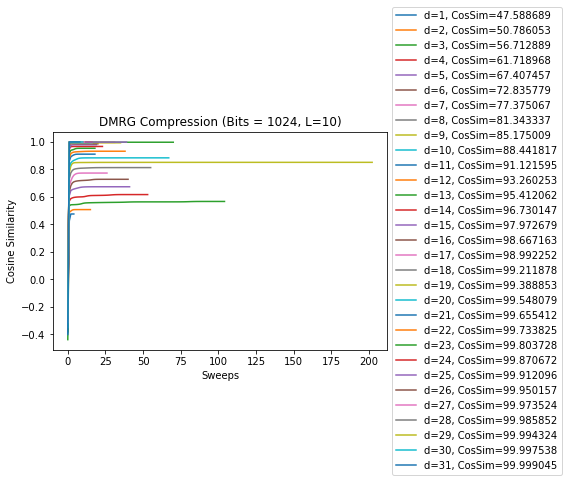

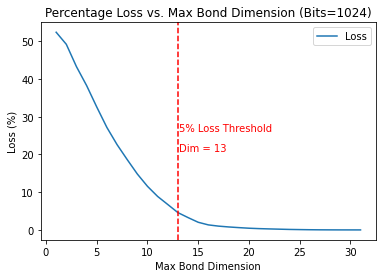

In [7]:
# Physical dimension
d = 2
data = rawData(bits=1024, phys_dim=d)
compressed_data = compressedData(data.MPS, phys_dim=d)

# DMRG

In [14]:
L = 5
d = 2

In [30]:
# Generates right normalized MPS
MPS = randomState(num_sites=L, max_bond_dim=20, phys_dim=d).MPS
MPO = initialize_quantum_ising(num_particles = L)

In [31]:
TN = Network(MPS, MPO, MPS)

In [32]:
TN.expectation_value

9.948726592862688

In [38]:
E = TN.expectation_value / scalar_product(TN.bra, TN.ket)

In [34]:
def ground_state_search(MPS, MPO, MPS):
    # MPS must be right normalized
    # We sweep left to right and then back right to left across the mixed state
    while True:
        E = calculate_expectation(MPS, MPO, MPS, vert_dir='down', horiz_dir='right') / scalar_product(MPS, MPS)
        # Left->right sweep
        for site in range(0, len(MPS)-1):
            MPS[site], MPS[site+1] = update_site(MPS, raw_state, site=site, dir='right')

        # Right->left sweep
        for site in range(len(MPS)-1, 0, -1):
            MPS[site], MPS[site-1] = update_site(MPS, raw_state, site=site, dir='left')


In [ ]:
def contract_L(bra, MPO, ket, site):
    for i in range(0, site):
        if i == site-1:
            # (r x l x 2), (r x l x 2 x 2), (r x l x 2) -> (rrr) x (lll)
            tensor = np.einsum('ijk, abkn, lmn->ialjbm', bra[i], MPO[i], ket[i])
            L = np.reshape(tensor, (tensor[0]*tensor[1]*tensor[2], tensor[3], tensor[4], tensor[5]))
        else:
            tensor = contract_vertical(bra[i], MPO[i], dir='down')
            tensor = contract_vertical(tensor, ket[i], dir='down')

        if i == 1:
            L = tensor
        else:
            L = np.dot(L, tensor)

def update_site_DMRG(bra, MPO, ket, site, dir):
    ### L TENSOR WITH SHAPE (bondDim_compressed, bondDim_raw) ###
    L = []
    for i in range(0, site):
        if i == site:
            
        tensor = contract_vertical(bra[i], MPO[i], ket[i])
        L = 







        if i == 0:  # Left bound
            if i == site-1:  # L tensor is the left bound only
                L = np.einsum('ij, ib->jb', bra[i], ket[i])
            else:
                pos = np.einsum('ij, ib->jb', bra[i], ket[i])
                pos = np.reshape(pos, (bra[i].shape[1]*ket[i].shape[1]))
                L = pos
        elif i == site-1:  # We need to keep the leg of the bra that connects to the missing tensor
            pos = np.einsum('ijk, abk->iajb', bra[i], ket[i])
            # (ia) will connect to previous L, (j) will be left bond of final tensor, (b) will connect to M
            # -> (Left bond, final tensor leg, connects to M)
            pos = np.reshape(pos, (bra[i].shape[0]*ket[i].shape[0], bra[i].shape[1], ket[i].shape[1]))

            # L has shape (final tensor left bond, connects to M left bond)
            L = np.einsum('i, ibc->bc', L, pos)
        else:  # Inner sites
            pos = np.einsum('ijk, abk->iajb', bra[i], ket[i])
            pos = np.reshape(pos, (bra[i].shape[0]*ket[i].shape[0], bra[i].shape[1]*ket[i].shape[1]))
            L = np.einsum('i, ij->j', L, pos)

    ### M TENSOR AT SITE, UNCHANGED ###
    M = ket[site]

    ### R TENSOR WITH SHAPE (bondDim_compressed, bondDim_raw) ###
    for i in range(len(bra)-1, site, -1):
        if i == len(bra)-1:
            if i == site+1:  # R tensor is the right bound only
                R = np.einsum('ij, ib->jb', bra[i], ket[i])
            else:
                pos = np.einsum('ij, ib->jb', bra[i], ket[i])
                pos = np.reshape(pos, (bra[i].shape[1]*ket[i].shape[1]))
                R = pos

        elif i == site+1:  # We need to keep the leg of the bra that connects to the missing tensor
            pos = np.einsum('ijk, abk->iajb', bra[i], ket[i])
            # (i) will be right bond of final tensor, (a) will connect to M, (jb) will connect to previous R
            # -> (Left bond, right bond, final tensor left leg)
            pos = np.reshape(pos, (bra[i].shape[0], ket[i].shape[0], bra[i].shape[1]*ket[i].shape[1]))
            # R has shape (Connects to M right bound, final tensor right bound)

            R = np.einsum('ijk, k->ij', pos, R)

        else:  # Inner sites
            pos = np.einsum('ijk, abk->iajb', bra[i], ket[i])
            pos = np.reshape(pos, (bra[i].shape[0]*ket[i].shape[0], bra[i].shape[1]*ket[i].shape[1]))
            R = np.einsum('ij, j->i', pos, R)

    ### CONTRACT M' = LMR ###
    if site == 0:
        updated_M = np.einsum('ij, aj->ia', M, R)
    elif site == len(bra)-1:
        updated_M = np.einsum('ij, aj->ai', L, M)
    else:
        updated_M = np.einsum('ij, jbc, ab->iac', L, M, R)

    ### UPDATING SITES ###

    # For a left->right sweep, similar to left normalization
    if dir == 'right':
        # Inner tensor needs to be reshaped
        if updated_M.ndim == 3:
            reshaped_M = np.transpose(updated_M, (0, 2, 1))  # Move left bond and physical dimension together
            reshaped_M = np.reshape(reshaped_M, (reshaped_M.shape[0]*reshaped_M.shape[1], reshaped_M.shape[2]))
            U, S_vector, V = np.linalg.svd(reshaped_M, full_matrices=False)
            A_tensor = np.reshape(U, (bra[site].shape[0], bra[site].shape[2], U.shape[1]))
            A_tensor = np.transpose(A_tensor, (0, 2, 1))
        else:
            U, S_vector, V = np.linalg.svd(updated_M, full_matrices=False)
            A_tensor = U

        lambda_tensor = np.diag(S_vector)

        if site == len(bra)-2:  # Multiplies with matrix on right bound (dim 2 x d)
            next_site_M = np.einsum('ij, jb, lb->li', lambda_tensor, V, bra[site+1])
        else:
            next_site_M = np.einsum('ij, jb, bmn->imn', lambda_tensor, V, bra[site+1])

        updated_site = A_tensor

    # For a right->left sweep, similar to right normalization
    elif dir == 'left':
        if updated_M.ndim == 3:
            reshaped_M = np.reshape(updated_M, (updated_M.shape[0], updated_M.shape[1]*updated_M.shape[2]))
            U, S_vector, V = np.linalg.svd(reshaped_M, full_matrices=False)
            B_tensor = np.reshape(V, (V.shape[0], bra[site].shape[1], bra[site].shape[2]))
        else:
            U, S_vector, V = np.linalg.svd(updated_M.T, full_matrices=False)  # Transpose to have shape (2 x d)
            B_tensor = V.T

        lambda_tensor = np.diag(S_vector)

        if site == 1:
            next_site_M = np.einsum('ij, jb, bm->im', bra[site-1], U, lambda_tensor)
        else:
            next_site_M = np.einsum('ijk, jb, bm->imk', bra[site-1], U, lambda_tensor)

        updated_site = B_tensor

    return updated_site, next_site_M